# Visualizing heatmaps of class activation
(this version works only with tensorflow backend)

In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


In [2]:
#import warnings
#warnings.filterwarnings('ignore')

### Import model

In [3]:
model = VGG16(weights='imagenet')

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Import image of a cat

In [5]:
base_dir = './cats_and_dogs_small/'
img_path = base_dir + '/test/cats/cat.1792.jpg'

In [6]:
img = image.load_img(img_path, target_size=(224, 224))

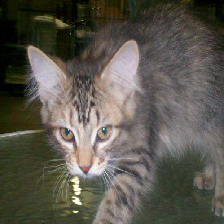

In [7]:
img

In [8]:
#image to array
x = image.img_to_array(img)
#add a dimension
x = np.expand_dims(x, axis=0)
#preprocess
x = preprocess_input(x)

### Prediction

In [9]:
preds = model.predict(x)

In [10]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02123159', 'tiger_cat', 0.50130457), ('n02123045', 'tabby', 0.33033875), ('n02124075', 'Egyptian_cat', 0.076164566)]


In [11]:
# Determine which class correspond to a tiger_cat
class_idx = np.argmax(preds[0])
class_idx

282

## Grad-CAM algorithm

In [12]:
tiger_cat_output = model.output[:, class_idx]

In [13]:
#extract last conv layer:
last_conv_layer = model.get_layer('block5_conv3')

#### Note: the following step works only with tensorflow as backend

In [14]:
# gradient of the “cat” class with regard to the output feature map of block5_conv3
grads = K.gradients(tiger_cat_output, last_conv_layer.output)[0]

In [15]:
# Vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature-map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [16]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [17]:
pooled_grads_value, conv_layer_output_value = iterate([x])

In [18]:
# Multiplies each channel in the feature-map array by “how important this channel is” with regard to the “tiger_cat” class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [19]:
conv_layer_output_value.shape

(14, 14, 512)

In [20]:
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [21]:
heatmap.shape

(14, 14)

### Tiger cat class activation heatmap over the test picture

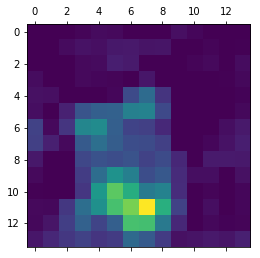

In [22]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

### Superimposing the heatmap with the original picture

In [23]:
img = cv2.imread(img_path)

In [24]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

In [25]:
heatmap = np.uint8(255 * heatmap)

In [26]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [27]:
#superimposed_img = heatmap * 0.4 + img
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

In [28]:
print(superimposed_img.shape)

(375, 499, 3)


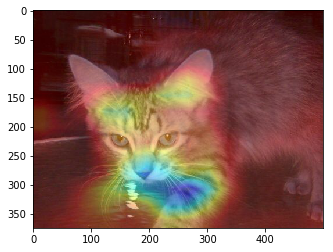

In [29]:
plt.imshow(superimposed_img)
plt.show()